In [18]:
from pyproj import Transformer
from sgp4.api import Satrec, jday
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from wmm2020 import wmm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

# TLE del satélite
line1 = "1 00000U 20000A   25015.00000000  .00000000  00000-0  00000-0 0  9991"
line2 = "2 00000  97.3400 313.1310 0000000  0.0000  0.0000 15.09556778000000"

# Crear el objeto del satélite
satellite = Satrec.twoline2rv(line1, line2)

# Fecha inicial y final
start_date = datetime(2025, 1, 15)
end_date = start_date + timedelta(days=0.5)

# Intervalo de tiempo en horas
time_step = timedelta(hours=0.05)

# Transformer para convertir ECEF a geodésico (WGS84)
transformer = Transformer.from_crs("EPSG:4978", "EPSG:4326", always_xy=True)

# Almacenar resultados
results = []

# Función para calcular GMST
def calculate_gmst(jd_full):
    T = (jd_full - 2451545.0) / 36525.0
    gmst_deg = 280.46061837 + 360.98564736629 * (jd_full - 2451545.0) + T**2 * (0.000387933 - T / 38710000.0)
    return np.radians(gmst_deg % 360)

# Propagar para cada intervalo de tiempo
current_time = start_date
while current_time <= end_date:
    jd, fr = jday(current_time.year, current_time.month, current_time.day,
                  current_time.hour, current_time.minute, current_time.second)

    error_code, position, velocity = satellite.sgp4(jd, fr)

    if error_code == 0:
        x_eci, y_eci, z_eci = position
        gmst = calculate_gmst(jd + fr)

        # Convertir ECI a ECEF
        x_ecef = x_eci * np.cos(gmst) + y_eci * np.sin(gmst)
        y_ecef = -x_eci * np.sin(gmst) + y_eci * np.cos(gmst)
        z_ecef = z_eci

        # Convertir ECEF a geodésico
        lon, lat, alt = transformer.transform(x_ecef * 1e3, y_ecef * 1e3, z_ecef * 1e3)

        # Calcular el campo magnético
        field = wmm(lon, lat, alt / 1000, current_time.year)
        north, east, down = field.north, field.east, field.down

        # Convertir componentes del campo magnético a ECEF
        lat_rad = np.radians(lat)
        lon_rad = np.radians(lon)
        bx_ecef = (-np.sin(lat_rad) * np.cos(lon_rad) * north -
                   np.sin(lon_rad) * east -
                   np.cos(lat_rad) * np.cos(lon_rad) * down)
        by_ecef = (-np.sin(lat_rad) * np.sin(lon_rad) * north +
                   np.cos(lon_rad) * east -
                   np.cos(lat_rad) * np.sin(lon_rad) * down)
        bz_ecef = np.cos(lat_rad) * north - np.sin(lat_rad) * down

        # Rotar de ECEF a ECI
        bx_eci = bx_ecef * np.cos(gmst) - by_ecef * np.sin(gmst)
        by_eci = bx_ecef * np.sin(gmst) + by_ecef * np.cos(gmst)
        bz_eci = bz_ecef

        # Almacenar resultados
        results.append({
            "Time (UTC)": current_time,
            "ECI X (km)": x_eci,
            "ECI Y (km)": y_eci,
            "ECI Z (km)": z_eci,
            "ECEF X (km)": x_ecef,
            "ECEF Y (km)": y_ecef,
            "ECEF Z (km)": z_ecef,
            "Latitude (deg)": lat,
            "Longitude (deg)": lon,
            "Altitude (m)": alt,
            "B N": north,
            "B E": east,
            "B D": down,
            "B Mag": field.total,
            "Bx ECEF (nT)": bx_ecef,
            "By ECEF (nT)": by_ecef,
            "Bz ECEF (nT)": bz_ecef,
            "Bx ECI (nT)": bx_eci,
            "By ECI (nT)": by_eci,
            "Bz ECI (nT)": bz_eci
        })
    else:
        print(f"Error en la propagación para {current_time}: código {error_code}")

    current_time += time_step

# Convertir resultados a DataFrame y guardar en CSV
df = pd.DataFrame(results)
df.to_csv("satellite_propagation_results.csv", index=False)
print("Resultados guardados en 'satellite_propagation_results.csv'")


Resultados guardados en 'satellite_propagation_results.csv'


In [19]:
# Function to create a sphere representing the Earth
def create_earth(radius=6371.0, resolution=50):
    # Sphere generation
    phi = np.linspace(0, 2 * np.pi, resolution)
    theta = np.linspace(0, np.pi, resolution)
    x = radius * np.outer(np.cos(phi), np.sin(theta))
    y = radius * np.outer(np.sin(phi), np.sin(theta))
    z = radius * np.outer(np.ones_like(phi), np.cos(theta))
    return x.flatten(), y.flatten(), z.flatten()

# Generate Earth data
earth_x, earth_y, earth_z = create_earth()

# Satellite trajectory data
eci_x = df["ECI X (km)"].values
eci_y = df["ECI Y (km)"].values
eci_z = df["ECI Z (km)"].values

# Create a 3D plot
fig = go.Figure()

# Add Earth to the plot
fig.add_trace(go.Surface(
    x=earth_x.reshape(50, 50),
    y=earth_y.reshape(50, 50),
    z=earth_z.reshape(50, 50),
    colorscale="Blues",
    opacity=0.5,
    name="Earth",
    showscale=False
))

# Add satellite trajectory
fig.add_trace(go.Scatter3d(
    x=eci_x,
    y=eci_y,
    z=eci_z,
    mode='lines',
    line=dict(color='red', width=4),
    name='Satellite Path'
))

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title="X (km)",
        yaxis_title="Y (km)",
        zaxis_title="Z (km)",
        aspectmode="data"  # Equal aspect ratio
    ),
    title="Satellite Trajectory in ECI Coordinates with Earth",
    showlegend=True
)

# Show the plot
fig.show()

In [20]:
# Function to create a sphere representing the Earth
def create_earth(radius=6371.0, resolution=50):
    # Sphere generation
    phi = np.linspace(0, 2 * np.pi, resolution)
    theta = np.linspace(0, np.pi, resolution)
    x = radius * np.outer(np.cos(phi), np.sin(theta))
    y = radius * np.outer(np.sin(phi), np.sin(theta))
    z = radius * np.outer(np.ones_like(phi), np.cos(theta))
    return x.flatten(), y.flatten(), z.flatten()

# Generate Earth data
earth_x, earth_y, earth_z = create_earth()

# Satellite trajectory data
ecef_x = df["ECEF X (km)"].values
ecef_y = df["ECEF Y (km)"].values
ecef_z = df["ECEF Z (km)"].values

# Create a 3D plot
fig = go.Figure()

# Add Earth to the plot
fig.add_trace(go.Surface(
    x=earth_x.reshape(50, 50),
    y=earth_y.reshape(50, 50),
    z=earth_z.reshape(50, 50),
    colorscale="Blues",
    opacity=0.5,
    name="Earth",
    showscale=False
))

# Add satellite trajectory
fig.add_trace(go.Scatter3d(
    x=ecef_x,
    y=ecef_y,
    z=ecef_z,
    mode='lines',
    line=dict(color='red', width=4),
    name='Satellite Path'
))

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title="X (km)",
        yaxis_title="Y (km)",
        zaxis_title="Z (km)",
        aspectmode="data"  # Equal aspect ratio
    ),
    title="Satellite Trajectory in ECEF Coordinates with Earth",
    showlegend=True
)

# Show the plot
fig.show()

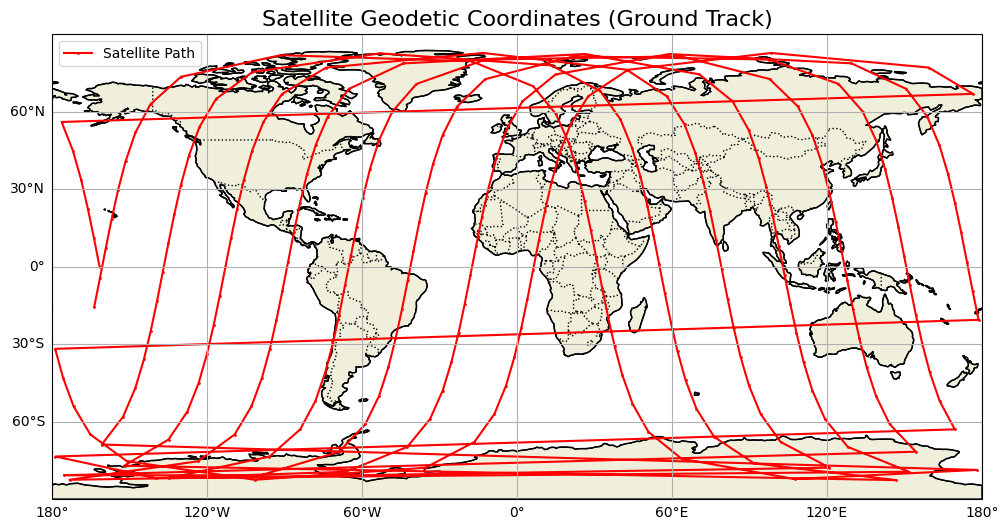

In [21]:
# Load the data from the CSV
df = pd.read_csv("satellite_propagation_results.csv")

# Create a figure with Cartopy projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.LAND, edgecolor="black")
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Plot the satellite path
ax.plot(
    df["Longitude (deg)"],
    df["Latitude (deg)"],
    marker="o",
    markersize=1,
    linestyle="-",
    color="red",
    label="Satellite Path",
    transform=ccrs.PlateCarree(),
)

# Add gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Set the title and legend
ax.set_title("Satellite Geodetic Coordinates (Ground Track)", fontsize=16)
ax.legend()

# Show the plot
plt.show()


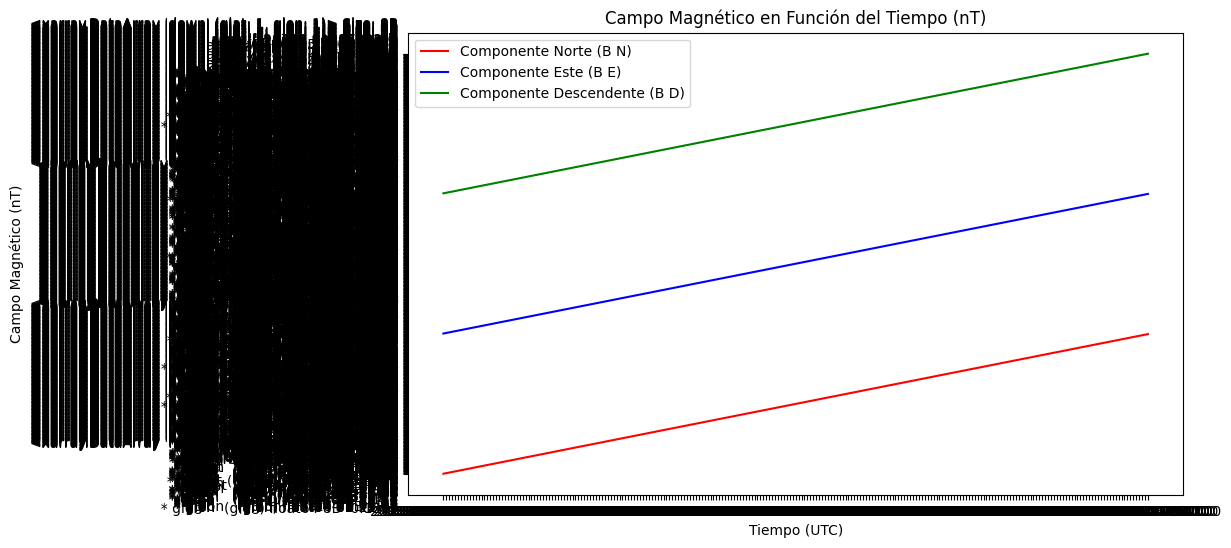

In [25]:
# Graficar el campo magnético en función del tiempo
plt.figure(figsize=(10, 6))

# Graficar cada componente del campo magnético
plt.plot(df["Time (UTC)"], df["B N"], label="Componente Norte (B N)", color="red")
plt.plot(df["Time (UTC)"], df["B E"], label="Componente Este (B E)", color="blue")
plt.plot(df["Time (UTC)"], df["B D"], label="Componente Descendente (B D)", color="green")

# Configurar el gráfico
plt.title("Campo Magnético en Función del Tiempo (nT)")
plt.xlabel("Tiempo (UTC)")
plt.ylabel("Campo Magnético (nT)")
plt.legend()

# Mostrar el gráfico
plt.show()

In [23]:
import numpy as np
import sequential_test as test
import time

# Initialize coil parameters
Z_coil = test.CoilParameters(1.03, 0.5, 20)
Y_coil = test.CoilParameters(1.02, 0.5, 35)
X_coil = test.CoilParameters(1.03, 0.85, 36)

# Current coil simulation
I = np.array([1,2,3])

# X coil simulation
grid_length_size = 0.05
num_seg = 1000

Rangex = test.generate_range(X_coil.a, grid_length_size)
Ax = np.eye(3)
start_time = time.time()
x_coil_results = test.coil_simulation_1d(Rangex, Ax, X_coil, I[0], num_seg)
# Marcar el tiempo de fin
end_time = time.time()

# Calcular y mostrar el tiempo de ejecución
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time} segundos")


Simulation Progress:   5%|▍         | 91/1936 [01:18<27:50,  1.10it/s]

KeyboardInterrupt: 